# Value at Risk (VaR) and GARCH Model Analysis

There are several methods to evaluate risk for an individual stock or a portfolio, such as variance, standard deviation of returns, et al. But, those measures do not consider a probability distribution. However, many risk managers prefer a simple measure called Value at Risk (VaR).

**VaR** is one of the most important metrics that is used to measure the risk associated with a financial position or a portfolio of financial instruments and can be defined as

`the maximum loss with a confidence level over a predetermined period`.

Let's say that the 1-day 95% VaR of our portfolio is $100. This means that 95% of the time, it is expected that - under normal market conditions - we will not lose more than $100 by holding our portfolio over one day.

Some of the approaches that are commonly used in the industry are covered in this analysis.

## Install Packages

Install the following packages (if not done already).

## Import Libraries

We'll import the required libraries that we'll use in this example.

In [1]:
# Import warnings
import warnings
warnings.filterwarnings('ignore')

# Import data manipulation libraries
import pandas as pd
import numpy as np
from pprint import pprint
from collections import OrderedDict
from numpy.linalg import multi_dot
from scipy import stats
from tabulate import tabulate

# Import Yahoo Finance
import yfinance as yf

# Import plotly express
import plotly.express as px
px.defaults.width, px.defaults.height = 1000, 600

# Set precision
pd.set_option('display.precision', 4)

## Retrieve Data from Yahoo Finance

We will retrieve stock prices from Yahoo Finance to build for VaR calculation. We'll use Indian stock symbols with .NS suffix for NSE (National Stock Exchange).

In [2]:
# Specify assets / stocks with NSE suffix
assets = ['ICICIBANK.NS', 'ITC.NS', 'RELIANCE.NS', 'TCS.NS', 'ASIANPAINT.NS']
asset_names = ['ICICIBANK', 'ITC', 'RELIANCE', 'TCS', 'ASIANPAINT']
print("Assets to download:", assets)

Assets to download: ['ICICIBANK.NS', 'ITC.NS', 'RELIANCE.NS', 'TCS.NS', 'ASIANPAINT.NS']


In [3]:
# Download stock data from Yahoo Finance
# Set the period for data download (e.g., 2 years of data)
df = yf.download(assets, period="2y", interval="1d")['Close']

# Rename columns to remove .NS suffix for cleaner column names
df.columns = asset_names

# View dataframe
print(f"Data shape: {df.shape}")
print(f"Date range: {df.index[0]} to {df.index[-1]}")
df.head()

[*********************100%***********************]  5 of 5 completed

Data shape: (496, 5)
Date range: 2023-09-26 00:00:00 to 2025-09-26 00:00:00


,ICICIBANK,ITC,RELIANCE,TCS,ASIANPAINT
Date,,,,,
2023-09-26,3220.2810,933.4004,414.1580,1162.6448,3474.4810
2023-09-27,3229.0828,927.8906,420.4296,1175.7478,3477.9692
2023-09-28,3100.5281,927.3987,412.5667,1158.4757,3427.0493
2023-09-29,3091.4326,936.5488,415.9833,1163.8856,3419.1523
2023-10-03,3097.1050,925.1358,411.6307,1150.5592,3404.8601


In [4]:
# Handle any missing data
df = df.dropna()
print(f"Data shape after removing NaN: {df.shape}")
df.tail()

Data shape after removing NaN: (496, 5)


,ICICIBANK,ITC,RELIANCE,TCS,ASIANPAINT
Date,,,,,
2025-09-22,2482.7000,1401.5,406.95,1390.6,3073.8000
2025-09-23,2446.8999,1394.3,403.20,1389.8,3062.3999
2025-09-24,2457.2000,1382.7,401.00,1383.0,3035.3999
2025-09-25,2404.0000,1375.8,400.10,1372.4,2957.3999
2025-09-26,2342.8000,1359.6,405.10,1377.6,2899.1001


In [5]:
# Calculate daily returns
returns = df.pct_change().dropna()
print(f"Returns shape: {returns.shape}")
returns.head()

Returns shape: (495, 5)


,ICICIBANK,ITC,RELIANCE,TCS,ASIANPAINT
Date,,,,,
2023-09-27,0.0027,-0.0059,0.0151,0.0113,0.0010
2023-09-28,-0.0398,-0.0005,-0.0187,-0.0147,-0.0146
2023-09-29,-0.0029,0.0099,0.0083,0.0047,-0.0023
2023-10-03,0.0018,-0.0122,-0.0105,-0.0114,-0.0042
2023-10-04,0.0010,-0.0109,-0.0083,-0.0017,0.0068


## Parametric VaR (Variance-Covariance Method)

The Variance-covariance is a parametric method which assumes (almost always) that the returns are normally distributed. In this method, we first calculate the mean and standard deviation of the returns to derive the risk metric. Based on the assumption of normality, we can generalise:

$$ VaR = position * (\mu - z * \sigma) $$

|Confidence Level|Value At Risk|
|--|--|
|`90%`|$\mu$ - $1.29$ * $\sigma$|
|`95%`|$\mu$ - $1.64$ * $\sigma$|
|`99%`|$\mu$ - $2.33$ * $\sigma$|

where, $\mu$ is the mean return, $\sigma$ is the volatility and $z$ is the number of standard deviation from the mean.

In [6]:
# Stock returns for ICICIBANK
stockreturn = returns['ICICIBANK']

# Calculate mean and standard deviation
mean = np.mean(stockreturn)
stdev = np.std(stockreturn)

print(f"Mean daily return: {mean:.6f}")
print(f"Daily volatility: {stdev:.6f}")

# Calculate VaR at different confidence levels
VaR_90 = stats.norm.ppf(1-0.90, mean, stdev)
VaR_95 = stats.norm.ppf(1-0.95, mean, stdev)
VaR_99 = stats.norm.ppf(1-0.99, mean, stdev)

Mean daily return: -0.000564
Daily volatility: 0.012516


In [7]:
# Output results in tabular format
table = [['90%', VaR_90], ['95%', VaR_95], ['99%', VaR_99]]
header = ['Confidence Level', 'Value At Risk']
print(tabulate(table, headers=header, floatfmt='.6f'))

Confidence Level      Value At Risk
------------------  ---------------
90%                       -0.016603
95%                       -0.021150
99%                       -0.029680


## Historical VaR

Asset returns do not necessarily follow a normal distribution. An alternative is to use sorted returns to evaluate a VaR. This method uses historical data where returns are sorted in ascending order to calculate maximum possible loss for a given confidence level.

In [8]:
# Use quantile function for Historical VaR
hVaR_90 = returns['ICICIBANK'].quantile(0.10)
hVaR_95 = returns['ICICIBANK'].quantile(0.05)
hVaR_99 = returns['ICICIBANK'].quantile(0.01)

In [9]:
# Output results in tabular format
htable = [['90%', hVaR_90], ['95%', hVaR_95], ['99%', hVaR_99]]
print(tabulate(htable, headers=header, floatfmt='.6f'))

Confidence Level      Value At Risk
------------------  ---------------
90%                       -0.014520
95%                       -0.020542
99%                       -0.035347


## Monte Carlo VaR

The Monte Carlo simulation approach has a number of similarities to historical simulation. It allows us to use actual historical distributions rather than having to assume normal returns. As returns are assumed to follow a normal distribution, we could generate simulated returns with the same mean and standard deviation (derived from the daily returns) and then sorted in ascending order to calculate maximum possible loss for a given confidence level.

In [10]:
# Set seed for reproducibility
np.random.seed(42)

# Number of simulations
n_sims = 5000

# Simulate returns and sort
sim_returns = np.random.normal(mean, stdev, n_sims)

# Use percentile function for MCVaR
MCVaR_90 = np.percentile(sim_returns, 10)
MCVaR_95 = np.percentile(sim_returns, 5)
MCVaR_99 = np.percentile(sim_returns, 1)

In [11]:
# Output results in tabular format
mctable = [['90%', MCVaR_90], ['95%', MCVaR_95], ['99%', MCVaR_99]]
print(tabulate(mctable, headers=header, floatfmt='.6f'))

Confidence Level      Value At Risk
------------------  ---------------
90%                       -0.016451
95%                       -0.020760
99%                       -0.030139


## Testing for Normality

In the Parametric VaR, we assumed that the returns are normally distributed. However, in the real world, we know that stock / portfolio returns do not necessarily follow a normal distribution. Let's perform a quick check to determine the normality of the underlying returns and see whether we need to modify our approach in deriving the VaR numbers.

The Shapiro-Wilk test is a test of normality and is used to determine whether or not a sample comes from a normal distribution.

In [12]:
# Normality test
shapiro_stat, shapiro_p = stats.shapiro(stockreturn)
print(f"Shapiro-Wilk Test:")
print(f"Statistic: {shapiro_stat:.6f}")
print(f"P-value: {shapiro_p:.6f}")
print(f"Result: {'Normal distribution' if shapiro_p > 0.05 else 'Not normal distribution'}")

Shapiro-Wilk Test:
Statistic: 0.953609
P-value: 0.000000
Result: Not normal distribution


Our null hypothesis is that the stock's daily returns follows a normal distribution. Since the p-value is less than 0.05, we reject the null hypothesis. We have sufficient evidence to say that the sample data does not come from a normal distribution.

Alternatively, we can perform an Anderson-Darling Test. It is a goodness of fit test that measures how well the data fit a specified distribution.

In [13]:
# Anderson-Darling normality test
anderson_result = stats.anderson(stockreturn)
print(f"Anderson-Darling Test:")
print(f"Statistic: {anderson_result.statistic:.6f}")
print(f"Critical Values: {anderson_result.critical_values}")
print(f"Significance Levels: {anderson_result.significance_level}")

Anderson-Darling Test:
Statistic: 4.257632
Critical Values: [0.571 0.651 0.781 0.911 1.083]
Significance Levels: [15.  10.   5.   2.5  1. ]


In [14]:
# Plot histogram
fig = px.histogram(returns, x='ICICIBANK', nbins=50,
                   histnorm='probability density',
                   title='Histogram of ICICIBANK Returns',
                   labels={'ICICIBANK': 'Daily Returns', 'count': 'Density'})
fig.show()

## Modified VaR

Standard normal distribution have a zero mean, unit variance, zero skewness, and its kurtosis of 3. However, we now know the distribution is not normal and in such scenario, the skewness and excess kurtosis of many stock returns are not zero. As a consequence, the modified VaR was developed to utilize those four moments instead of the first two moments.

$\mu$ is the return, $\sigma$ is the volatility, $s$ is the skewness, $k$ is the kurtosis and $z$ is the absolute number of standard deviation from the mean.

In [15]:
# First four moments
dist = OrderedDict({
    'Mean': np.mean(returns['ICICIBANK']),
    'Std Dev': np.std(returns['ICICIBANK']),
    'Skew': stats.skew(returns['ICICIBANK']),
    'Kurtosis': stats.kurtosis(returns['ICICIBANK'])
})
pprint(dist)

OrderedDict([('Mean', np.float64(-0.0005636351315100572)),
             ('Std Dev', np.float64(0.012515747169460049)),
             ('Skew', np.float64(-0.6389758118432279)),
             ('Kurtosis', np.float64(4.494764018598468))])


In [16]:
# Specify params for modified VaR
z = abs(stats.norm.ppf(0.01))
s = stats.skew(stockreturn)
k = stats.kurtosis(stockreturn)
t = z + 1/6*(z**2-1)*s + 1/24*(z**3-3*z)*k - 1/36*(2*z**3-5*z)*s**2

# Calculate VaR at difference confidence level
mVaR_99 = (mean - t*stdev)
print(f"Modified VaR (99%): {mVaR_99:.6f}")

Modified VaR (99%): -0.035028


## VaR Scaling

Now, let's calculate VaR over a 5-day period. To scale it, multiply by square root of time.

$$ VaR = position * (\mu - z * \sigma) * \sqrt{T}$$

where, $T$ is the horizon or forecast period.

In [17]:
# VaR Scaling
forecast_days = 5
f_VaR_90 = VaR_90 * np.sqrt(forecast_days)
f_VaR_95 = VaR_95 * np.sqrt(forecast_days)
f_VaR_99 = VaR_99 * np.sqrt(forecast_days)

In [18]:
# Output results in tabular format
ftable = [['90%', f_VaR_90], ['95%', f_VaR_95], ['99%', f_VaR_99]]
fheader = ['Confidence Level', '5-Day Forecast Value At Risk']
print(tabulate(ftable, headers=fheader, floatfmt='.6f'))

Confidence Level      5-Day Forecast Value At Risk
------------------  ------------------------------
90%                                      -0.037126
95%                                      -0.047293
99%                                      -0.066366


In [19]:
# Plot Scaled VaR
horizons = range(1, 101)
sVaR = [-100*VaR_99*np.sqrt(x) for x in horizons]
sVaR_df = pd.DataFrame({'Horizon': horizons, 'ScaledVaR': sVaR})
fig = px.line(sVaR_df, x='Horizon', y='ScaledVaR', 
              title='Scaled VaR over Different Time Horizons',
              labels={'ScaledVaR': 'Scaled VaR (%)'})
fig.show()

## Conditional Value at Risk (CVaR)

VaR is a reasonable measure of risk if assumption of normality holds. Else, we might underestimate the risk if we observe a fat tail or overestimate the risk if tail is thinner. Expected shortfall or Conditional Value at Risk (CVaR) is an estimate of expected shortfall sustained in the worst 1-x% of scenarios. It is defined as the average loss based on the returns that are lower than the VaR threshold.

In [20]:
# Calculate CVaR
CVaR_90 = returns['ICICIBANK'][returns['ICICIBANK'] <= hVaR_90].mean()
CVaR_95 = returns['ICICIBANK'][returns['ICICIBANK'] <= hVaR_95].mean()
CVaR_99 = returns['ICICIBANK'][returns['ICICIBANK'] <= hVaR_99].mean()

In [21]:
# Output results in tabular format
ctable = [['90%', CVaR_90], ['95%', CVaR_95], ['99%', CVaR_99]]
cheader = ['Confidence Level', 'Conditional Value At Risk']
print(tabulate(ctable, headers=cheader, floatfmt='.6f'))

Confidence Level      Conditional Value At Risk
------------------  ---------------------------
90%                                   -0.024257
95%                                   -0.031329
99%                                   -0.049362


## Portfolio VaR

If we know the returns and volatilities of all the assets in the portfolio, we can derive portfolio VaR. We will now derive VaR of minimum variance portfolio consisting of Indian stocks.

In [22]:
# Equal weights portfolio (you can modify these weights)
n_assets = len(asset_names)
wts = np.array([1/n_assets] * n_assets)  # Equal weights
print(f"Portfolio weights: {dict(zip(asset_names, wts))}")

# Portfolio mean returns and volatility
port_mean = wts.T @ returns.mean()
port_stdev = np.sqrt(multi_dot([wts.T, returns.cov(), wts]))
pVaR = stats.norm.ppf(1-0.99, port_mean, port_stdev)

print(f"Portfolio Mean: {port_mean:.6f}")
print(f"Portfolio Std Dev: {port_stdev:.6f}")
print(f"Portfolio VaR (99%): {pVaR:.6f}")

Portfolio weights: {'ICICIBANK': np.float64(0.2), 'ITC': np.float64(0.2), 'RELIANCE': np.float64(0.2), 'TCS': np.float64(0.2), 'ASIANPAINT': np.float64(0.2)}
Portfolio Mean: 0.000088
Portfolio Std Dev: 0.008072
Portfolio VaR (99%): -0.018691


## GARCH Model

Asset price volatility is central to derivatives pricing. It is defined as measure of price variability over certain period of time. In essence, it describes standard deviation of returns. There are different types of volatility: Historical, Implied, Forward. In most cases, we assume volatility to be constant, which is clearly not true and numerous studies have been dedicated to estimate this variable, both in academia and industry.

### Volatility Estimation

Volatility estimation by statistical means assume equal weights to all returns measured over the period. We know that over 1-day, the mean return is small as compared to standard deviation.

### ARCH Model

The ARCH model was originally developed by Robert Engle in 1982 to measure the dynamics of inflation uncertainty. Conditional heteroskedasticity refers to the notion that the next period's volatility is conditional on the volatility in the current period as well as to the time varying nature of volatility.

### GARCH Model

To address the shortcoming, ARCH has been extended to a generalised framework where we add volatility as a forecasting feature by adding previous variance. This method is popularly known as Generalized ARCH or GARCH model.

GARCH(1,1) is represented as: 

$$ \sigma^2_n = \omega + \alpha u^2_{n-1} + \beta \sigma^2_{n-1} $$

where, $\alpha + \beta < 1$ and $\gamma + \alpha + \beta = 1$ as weight applied to long term variance cannot be negative and $\frac {\omega} {(1-\alpha-\beta)}$ is the long-run variance.

In [23]:
# Import arch library
from arch import arch_model

In [24]:
# Convert returns to percentage for better convergence
stockreturn_pct = stockreturn * 100

# Mean zero GARCH model
print("Fitting GARCH(1,1) model...")
g1 = arch_model(stockreturn_pct, vol='GARCH', mean='Zero', p=1, q=1, dist='Normal')
model = g1.fit(disp='off')  # disp='off' to suppress optimization output
print("Model fitted successfully!")

Fitting GARCH(1,1) model...
Model fitted successfully!


In [25]:
# Model output
print(model)

                       Zero Mean - GARCH Model Results                        
Dep. Variable:              ICICIBANK   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.002
Vol Model:                      GARCH   Log-Likelihood:               -800.221
Distribution:                  Normal   AIC:                           1606.44
Method:            Maximum Likelihood   BIC:                           1619.06
                                        No. Observations:                  495
Date:                Sun, Sep 28 2025   Df Residuals:                      495
Time:                        06:23:28   Df Model:                            0
                              Volatility Model                             
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.9954      0.207      4.798  1.605e-06    [  

In [26]:
# Model summary
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:              ICICIBANK   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.002
Vol Model:                      GARCH   Log-Likelihood:               -800.221
Distribution:                  Normal   AIC:                           1606.44
Method:            Maximum Likelihood   BIC:                           1619.06
                                        No. Observations:                  495
Date:                Sun, Sep 28 2025   Df Residuals:                      495
Time:                        06:23:28   Df Model:                            0
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.9954      0.207      4.798  1.605e-06    [  0.589,  1.402]
alpha[1]       0.2376      0.132      1.801  7.177e-02 [-2.103e-02,  0.496]
beta[1]        0.1430      0.132      1.083      0.279    [ -0.116,  0.402]
===========================================================================

Covariance estimator: robust
"""

In [27]:
# Model parameters
print("Model Parameters:")
for param, value in model.params.items():
    print(f"{param}: {value:.6f}")

Model Parameters:
omega: 0.995365
alpha[1]: 0.237580
beta[1]: 0.143008


In [28]:
# Model Confidence Interval
conf_int = model.conf_int(alpha=.01)
print("99% Confidence Intervals:")
print(conf_int)

99% Confidence Intervals:
           lower   upper
omega     0.4610  1.5298
alpha[1] -0.1023  0.5775
beta[1]  -0.1973  0.4833


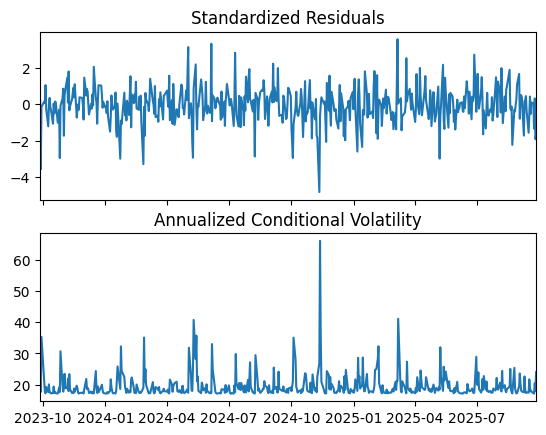

In [29]:
# Plot annualised volatility
fig = model.plot(annualize='D')

In [31]:
# Forecast for next 60 days
print("Generating volatility forecast...")

# Generate forecast
model_forecast = model.forecast(horizon=60)

# Extract variance forecast properly
forecast_var = model_forecast.variance.dropna()
forecast_values = forecast_var.iloc[-1, :].values  # Last row contains 60-day forecast

# Convert to annualized volatility percentage
forecast_vol_pct = np.sqrt(forecast_values * 252) * 100

# Create proper DataFrame
forecast_df = pd.DataFrame({
    'Days_Ahead': np.arange(1, len(forecast_vol_pct) + 1),
    'Volatility_Pct': forecast_vol_pct
})

# Create plot with explicit x and y
fig = px.line(forecast_df, x='Days_Ahead', y='Volatility_Pct',
              title='GARCH Volatility Forecast (60 Days)',
              labels={'Days_Ahead': 'Days Ahead', 
                     'Volatility_Pct': 'Annualized Volatility (%)'})
fig.update_traces(line_color='red')
fig.show()


Generating volatility forecast...


## Summary

This notebook demonstrates various Value at Risk (VaR) methodologies and GARCH volatility modeling using real stock data from Yahoo Finance. The analysis includes:

1. **Parametric VaR**: Assumes normal distribution of returns
2. **Historical VaR**: Uses empirical quantiles of historical returns
3. **Monte Carlo VaR**: Simulates returns based on historical parameters
4. **Modified VaR**: Incorporates skewness and kurtosis
5. **Conditional VaR (CVaR)**: Expected loss beyond VaR threshold
6. **Portfolio VaR**: Risk measurement for multi-asset portfolios
7. **GARCH Model**: Dynamic volatility forecasting

The Yahoo Finance integration makes this analysis easily reproducible with current market data for any publicly traded stocks.